In [4]:
#data and reps from here:
#https://github.com/henanjun/LCMR/blob/1/LCMR/LCMR_demo.m

#demo for LCMR to be appeared TGRS if you use code, please kind cite the paper, "A New Spatial-Spectral Feature Extraction Method for Hyperspectral Images Using Local Covariance Matrix Representation" Leyuan Fang et al. to be appeared TGRS

import numpy as np


from hand_utils import *

import sys
sys.path.append('../')
from scripts import flag_dimensionality_reduction as fdr
from scripts.utils import *

from matplotlib import pyplot as plt
from geomstats.geometry.pre_shape import PreShapeSpace

import pandas as pd


class GeomstatsShapeSpace():
    """A simple adapter class which uses pymanopt language for geomstats shape space
    """

    def __init__(self, n, k):
        self._man = PreShapeSpace(m_ambient = n, k_landmarks = k)
        self._man.equip_with_group_action("rotations")
        self._man.equip_with_quotient_structure()

    def dist(self, point_a, point_b):
        return self._man.metric.dist(point_a, point_b)

    def exp(self, base_point, tangent_vector):
        return self._man.metric.exp(tangent_vector, base_point=base_point)

    def log(self, base_point, ambient_point):
        return self._man.to_tangent(ambient_point, base_point=base_point)
    
    def random_point(self):
        return self._man.random_point()

In [6]:
dr_seed = 42

manifold = GeomstatsShapeSpace(2,56)


fl_type = [1,2]
results = pd.DataFrame(columns = ['Num. Outliers','Algorithm', 'Rec. Err.'])

for n_outs in [5,10,15,20,25,30,35,40]:

    # load data
    filepath = './all/shapes'
    segmentationlist = readSegmentations(filepath,getxy)[0]
    hands = np.array(segmentationlist).T


    shapes = []
    for h in hands:
        k_shape = unmake_1d(h)
        k_shape = k_shape - np.mean(k_shape, axis = 0)
        k_shape = k_shape/np.linalg.norm(k_shape)
        shapes.append(k_shape)

    shapes = shapes

    for i in range(n_outs):
        outlier = generate_hairball_outlier(i)
        shapes.append(outlier)

    labels = [0]*40 + [1]*n_outs

    #compute median
    mean_seed = 21
    median = fdr.karcher_median(manifold, shapes, seed = mean_seed)

    mean = fdr.karcher_mean(manifold, shapes, seed = mean_seed)


    fl_type = [1,2]

    [W_w1ours,_,_], ts     = fdr.flag_robust_tpca( manifold, shapes, fl_type = fl_type, pca_type = 'wpca', return_ts = True, 
                                        median = median, init = 'rand', rand_seed = dr_seed, verbose = False )
    [W_r1ours,_,_], ts     = fdr.flag_robust_tpca( manifold, shapes, fl_type = fl_type, pca_type = 'rpca', return_ts = True,
                                        median = median, init = 'rand', rand_seed = dr_seed, verbose = False )
    
    [W_w2ours,_,_], ts     = fdr.flag_robust_tpca( manifold, shapes, fl_type = [fl_type[-1]], pca_type = 'wpca', return_ts = True, 
                                        median = median, init = 'rand', rand_seed = dr_seed, verbose = False )
    [W_r2ours,_,_], ts     = fdr.flag_robust_tpca( manifold, shapes, fl_type = [fl_type[-1]], pca_type = 'rpca', return_ts = True,
                                        median = median, init = 'rand', rand_seed = dr_seed, verbose = False )

    #PCA
    W_pca, _, ts_pca, mean =         PGA0( manifold, shapes, [fl_type[-1]], return_ts = True, eps = 1e-9 )

    auc_val = np.sum(reconst_err_man(manifold, median, shapes[:40], ts[:,:40], W_w1ours ))
    row = pd.DataFrame(data = [[n_outs, 'L1-WPCA', auc_val]],
                    columns = results.columns)
    results = pd.concat([results, row])
    
    auc_val = np.sum(reconst_err_man(manifold, median, shapes[:40], ts[:,:40], W_r1ours))
    row = pd.DataFrame(data = [[n_outs, 'L1-RPCA', auc_val]],
                    columns = results.columns)
    results = pd.concat([results, row])
        

    auc_val = np.sum(reconst_err_man(manifold, median, shapes[:40], ts[:,:40], W_w2ours))
    row = pd.DataFrame(data = [[n_outs, 'L2-WPCA', auc_val]],
                    columns = results.columns)
    results = pd.concat([results, row])
    
    auc_val = np.sum(reconst_err_man(manifold, median, shapes[:40], ts[:,:40], W_r2ours ))
    row = pd.DataFrame(data = [[n_outs, 'L2-RPCA', auc_val]],
                    columns = results.columns)
    results = pd.concat([results, row])
        
    
    auc_val = np.sum(reconst_err_man(manifold, mean, shapes[:40], ts_pca[:,:40], W_pca))
    row = pd.DataFrame(data = [[n_outs, 'PCA', auc_val]],
                    columns = results.columns)
    results = pd.concat([results, row])

    print(results)
    
results.to_csv('../Results/rec_err.csv')


  Num. Outliers Algorithm  Rec. Err.
0             5   L1-WPCA   3.190306
0             5   L1-RPCA   4.792784
0             5   L2-WPCA   3.159390
0             5   L2-RPCA   4.331372
0             5       PCA   6.249168
  Num. Outliers Algorithm  Rec. Err.
0             5   L1-WPCA   3.190306
0             5   L1-RPCA   4.792784
0             5   L2-WPCA   3.159390
0             5   L2-RPCA   4.331372
0             5       PCA   6.249168
0            10   L1-WPCA   3.221717
0            10   L1-RPCA   5.721425
0            10   L2-WPCA   3.175703
0            10   L2-RPCA   4.766865
0            10       PCA   6.786160
  Num. Outliers Algorithm  Rec. Err.
0             5   L1-WPCA   3.190306
0             5   L1-RPCA   4.792784
0             5   L2-WPCA   3.159390
0             5   L2-RPCA   4.331372
0             5       PCA   6.249168
0            10   L1-WPCA   3.221717
0            10   L1-RPCA   5.721425
0            10   L2-WPCA   3.175703
0            10   L2-RPCA   4.766865
0

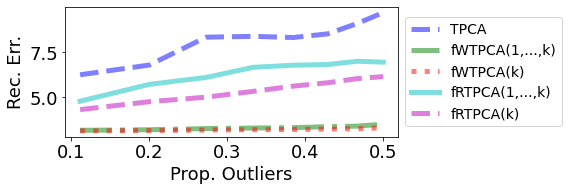

In [8]:
results = pd.read_csv('../Results/rec_err.csv')
plt.rcParams.update({'font.size': 18})
plt.figure(figsize = (8,3))

colors = ['b', 'g', 'r', 'c', 'm', 'y', 'indigo', 'maroon', 'teal', 'orange', 'purple', 'brown']
linestyles = ['--', '-.', ':', 'solid', 'dashed', 'dashdot', 'dotted', (0, (3, 1, 1, 1)), (0, (5, 2)), (0, (3, 1, 1, 1, 1, 1)), (0, (5, 2, 1, 2)), (0, (3, 1, 1, 1, 1, 1, 1, 1))]
ii = 0

for alg, lbl in zip(['PCA', 'L1-WPCA', 'L2-WPCA', 'L1-RPCA', 'L2-RPCA'],['TPCA', 'fWTPCA(1,...,k)', 'fWTPCA(k)', 'fRTPCA(1,...,k)', 'fRTPCA(k)']):

    y = results[results['Algorithm'] == f'{alg}']['Rec. Err.']
    x = results[results['Algorithm'] == f'{alg}']['Num. Outliers']
    plt.plot(x/(40+x),y,label = lbl, c = colors[ii], linestyle = linestyles[ii],  alpha = .5, linewidth = 5)

    ii+=1

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = 14)
plt.xlabel('Prop. Outliers')
plt.ylabel('Rec. Err.')

plt.tight_layout()
plt.savefig('../Results/rec_ablation.pdf', bbox_inches = 'tight')


In [9]:


dr_seed = 42

manifold = GeomstatsShapeSpace(2,56)


fl_type = [1]
results = pd.DataFrame(columns = ['Num. Outliers','Algorithm', 'Rec. Err.'])

for n_outs in [5,10,15,20,25,30,35,40]:

    # load data
    filepath = './all/shapes'
    segmentationlist = readSegmentations(filepath,getxy)[0]
    hands = np.array(segmentationlist).T


    shapes = []
    for h in hands:
        k_shape = unmake_1d(h)
        k_shape = k_shape - np.mean(k_shape, axis = 0)
        k_shape = k_shape/np.linalg.norm(k_shape)
        shapes.append(k_shape)

    shapes = shapes

    for i in range(n_outs):
        outlier = generate_hairball_outlier(i+10)
        shapes.append(outlier)

    labels = [0]*40 + [1]*n_outs

    #compute median
    mean_seed = 21
    median = fdr.karcher_median(manifold, shapes, seed = mean_seed)

    mean = fdr.karcher_mean(manifold, shapes, seed = mean_seed)


    fl_type = [1]

    [W_w1ours,_,_], ts     = fdr.flag_robust_tpca( manifold, shapes, fl_type = fl_type, pca_type = 'wpca', return_ts = True, 
                                        median = median, init = 'rand', rand_seed = dr_seed, verbose = False )
    [W_r1ours,_,_], ts     = fdr.flag_robust_tpca( manifold, shapes, fl_type = fl_type, pca_type = 'rpca', return_ts = True,
                                        median = median, init = 'rand', rand_seed = dr_seed, verbose = False )

    #PCA
    W_pca, _, ts_pca, mean =         PGA0( manifold, shapes, [fl_type[-1]], return_ts = True, eps = 1e-9 )

    auc_val = np.sum(reconst_err_man(manifold, median, shapes[:40], ts[:,:40], W_w1ours ))
    row = pd.DataFrame(data = [[n_outs, 'WPCA', auc_val]],
                    columns = results.columns)
    results = pd.concat([results, row])
    
    auc_val = np.sum(reconst_err_man(manifold, median, shapes[:40], ts[:,:40], W_r1ours))
    row = pd.DataFrame(data = [[n_outs, 'RPCA', auc_val]],
                    columns = results.columns)
    results = pd.concat([results, row])
        
        
    auc_val = np.sum(reconst_err_man(manifold, mean, shapes[:40], ts_pca[:,:40], W_pca))
    row = pd.DataFrame(data = [[n_outs, 'PCA', auc_val]],
                    columns = results.columns)
    results = pd.concat([results, row])

    print(results)
    
results.to_csv('../Results/rec_err1.csv')


  Num. Outliers Algorithm  Rec. Err.
0             5      WPCA   5.353989
0             5      RPCA   6.199973
0             5       PCA   8.185601
  Num. Outliers Algorithm  Rec. Err.
0             5      WPCA   5.353989
0             5      RPCA   6.199973
0             5       PCA   8.185601
0            10      WPCA   5.360252
0            10      RPCA   6.629122
0            10       PCA   8.753021
  Num. Outliers Algorithm  Rec. Err.
0             5      WPCA   5.353989
0             5      RPCA   6.199973
0             5       PCA   8.185601
0            10      WPCA   5.360252
0            10      RPCA   6.629122
0            10       PCA   8.753021
0            15      WPCA   5.368643
0            15      RPCA   6.719004
0            15       PCA   8.757685
  Num. Outliers Algorithm  Rec. Err.
0             5      WPCA   5.353989
0             5      RPCA   6.199973
0             5       PCA   8.185601
0            10      WPCA   5.360252
0            10      RPCA   6.629122
0

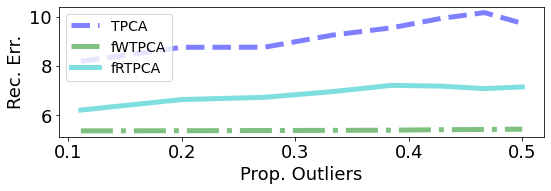

In [12]:
results = pd.read_csv('../Results/rec_err1.csv')
plt.rcParams.update({'font.size': 18})
plt.figure(figsize = (8,3))

colors = ['b', 'g', 'c']
linestyles = ['--', '-.', 'solid']
ii = 0

for alg, lbl in zip(['PCA', 'WPCA', 'RPCA'],['TPCA', 'fWTPCA', 'fRTPCA']):

    y = results[results['Algorithm'] == f'{alg}']['Rec. Err.']
    x = results[results['Algorithm'] == f'{alg}']['Num. Outliers']
    plt.plot(x/(40+x),y,label = lbl, c = colors[ii], linestyle = linestyles[ii], alpha = .5, linewidth = 5)

    ii+=1

plt.legend(fontsize = 14)
plt.xlabel('Prop. Outliers')
plt.ylabel('Rec. Err.')

plt.tight_layout()
plt.savefig('../Results/rec_ablation1.pdf', bbox_inches = 'tight')
